# Generalised Empirical Interpolation Method: online phase
This notebook takes the magic functions/sensors and performs the online phase of the Tikhonov regularisation of the Generalised Empirical Interpolation Method (TR-GEIM).

Let us create the mesh from the OpenFOAM nodes and cells

In [1]:
from pyforce.tools.write_read import ReadFromOF

path_snaps = '../../../Data/MSFR/'

of = ReadFromOF(path_snaps+'ULOFF-reflector/', mode='pyvista')
domain = of.create_mesh()

  warnings.warn('The mesh contains more than one cell type.')



Hexahedron cells selected


Let us import the snapshots, variable names and time

In [2]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('Results/times.npz')['fom_times']

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1))
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train, test and predict: predict include times $t>50$ seconds, train and test include times $t<50$ seconds, these are randomly selected.

In [4]:
from sklearn.model_selection import train_test_split

Nt = len(fom_times)
cut_train = int(0.9*Nt)

measured_field_i = 1
_indices = np.arange(0, cut_train)
train_indices, test_indices = train_test_split(_indices, test_size=0.2, random_state=42)

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)
predict_indices = np.arange(cut_train, Nt)

test_snaps = FunctionsList(fun_spaces[measured_field_i])
for ii in test_indices:
    test_snaps.append(snaps[var_names[measured_field_i]](ii) / snaps[var_names[measured_field_i]](0).max())

predict_snaps = FunctionsList(fun_spaces[measured_field_i])
for ii in predict_indices:
    predict_snaps.append(snaps[var_names[measured_field_i]](ii) / snaps[var_names[measured_field_i]](0).max())

Let us import the magic functions/sensors


In [5]:
from pyforce.tools.write_read import ImportH5

path_offline = 'Results/GEIM_offline/'
strategies = ['ID', 'Out']

magic_functions = {strategy: ImportH5(fun_spaces[measured_field_i],
                          path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_mf',
                          f'GEIM_{var_names[measured_field_i]}_{strategy}_mf')[0]
                for strategy in strategies}
magic_sensors = {strategy: ImportH5(fun_spaces[measured_field_i],
                          path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_ms',
                          f'GEIM_{var_names[measured_field_i]}_{strategy}_ms')[0]
                for strategy in strategies}

training_betas = {strategy: np.load(path_offline+f'GEIM_{var_names[measured_field_i]}_{strategy}_TrainBeta.npz')['arr_0']
                  for strategy in strategies}

mean_beta = {strategy: np.mean(training_betas[strategy], axis=0)
                for strategy in strategies}
std_beta = {strategy: np.std(training_betas[strategy], axis=0)
                for strategy in strategies}

## Online Phase
The online phase of the TR-GEIM is performed

### Interpolation regime
Let us now perform the online phase of TR-GEIM in interpolation regime

In [18]:
from pyforce.online.tr_geim import TRGEIM

trgeim = {strategy: TRGEIM(magic_functions[strategy],
                           magic_sensors[strategy],
                           mean_beta=mean_beta[strategy],
                           std_beta=std_beta[strategy], name = var_names[measured_field_i])
            for strategy in strategies}

Mmax = 20
noise_value = 5e-3

reg_params = noise_value**2

online_test_results = dict()

for strategy in strategies:
    print(f'Online testing for {strategy} strategy')
    _res = trgeim[strategy].synt_test_error(    test_snaps, 
                                                noise_value=noise_value, reg_param=reg_params, 
                                                M=25, verbose=False)

    online_test_results[strategy] = {
        'abs_err': _res[0],
        'rel_err': _res[1],
        'compt_time': _res[2]
    }


Online testing for ID strategy
The maximum number of measures must not be higher than 20 --> set equal to 20
Online testing for Out strategy
The maximum number of measures must not be higher than 20 --> set equal to 20


Let us plot the absolute and relative error of the TR-GEIM reconstruction for the different strategies.

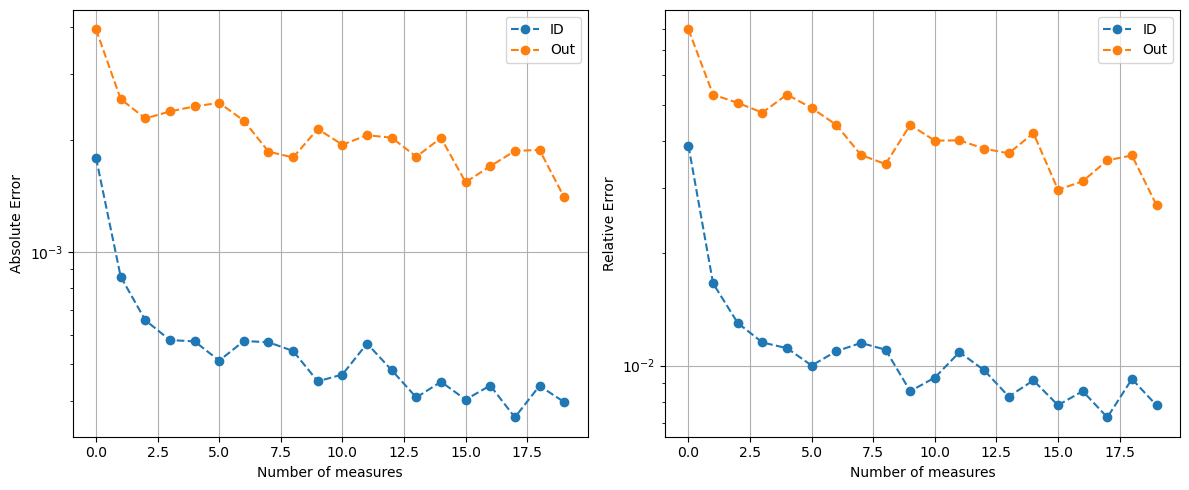

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for strategy in strategies:
    axs[0].plot(online_test_results[strategy]['abs_err'], 'o--', label=strategy)
    axs[1].plot(online_test_results[strategy]['rel_err'], 'o--', label=strategy)

for ax in axs:
    ax.grid()
    ax.set_xlabel('Number of measures')
    ax.set_yscale('log')
    ax.legend()

axs[0].set_ylabel('Absolute Error')
axs[1].set_ylabel('Relative Error')

plt.tight_layout()

Let us compare the computational time of the TR-GEIM estimation.

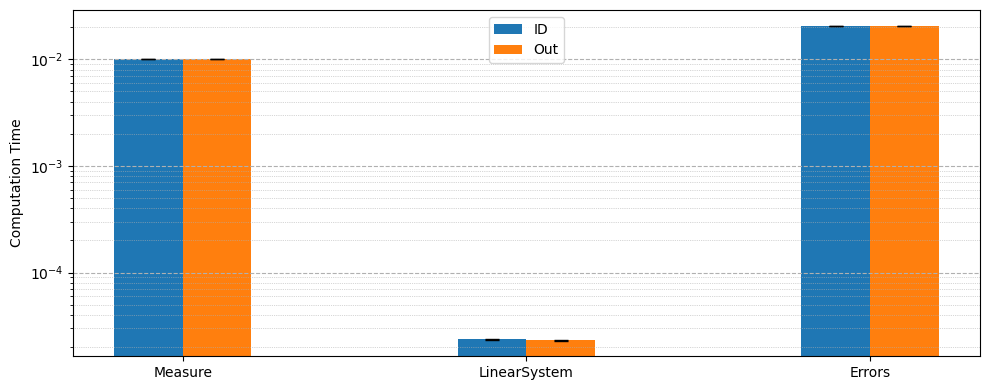

In [20]:
keys = ['Measure', 'LinearSystem', 'Errors']
strategies = list(online_test_results.keys())

# Prepare data
means = []
errors = []

for key in keys:
    key_means = []
    key_errors = []
    for strategy in strategies:
        data = np.array(online_test_results[strategy]['compt_time'][key])  
        mean_value = data.mean()
        std_err = data.std(ddof=1) / np.sqrt(data.size) 
        key_means.append(mean_value)
        key_errors.append(std_err)
    means.append(key_means)
    errors.append(key_errors)

means = np.array(means).T  
errors = np.array(errors).T

# Plot
x = np.arange(len(keys))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 4))
for i, strategy in enumerate(strategies):
    ax.bar(x + i*width, means[i], width, yerr=errors[i], label=strategy, capsize=5)

ax.set_xticks(x + width * (len(strategies)-1)/2)
ax.set_xticklabels(keys)
ax.set_ylabel('Computation Time')
ax.legend()
ax.set_yscale('log')
ax.grid(axis='y', linestyle='--')
ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5)

plt.tight_layout()

Let us make some contour plots of the TR-GEIM reconstruction for the different strategies.

At first, the reconstruction is generated.

In [21]:
recons = {
    strategy: np.array([trgeim[strategy].reconstruct(snap, M=Mmax, noise_value=noise_value, reg_param=reg_params)[0]
                        for snap in test_snaps._list])
    for strategy in strategies
}

Then, the contour plots are generated.

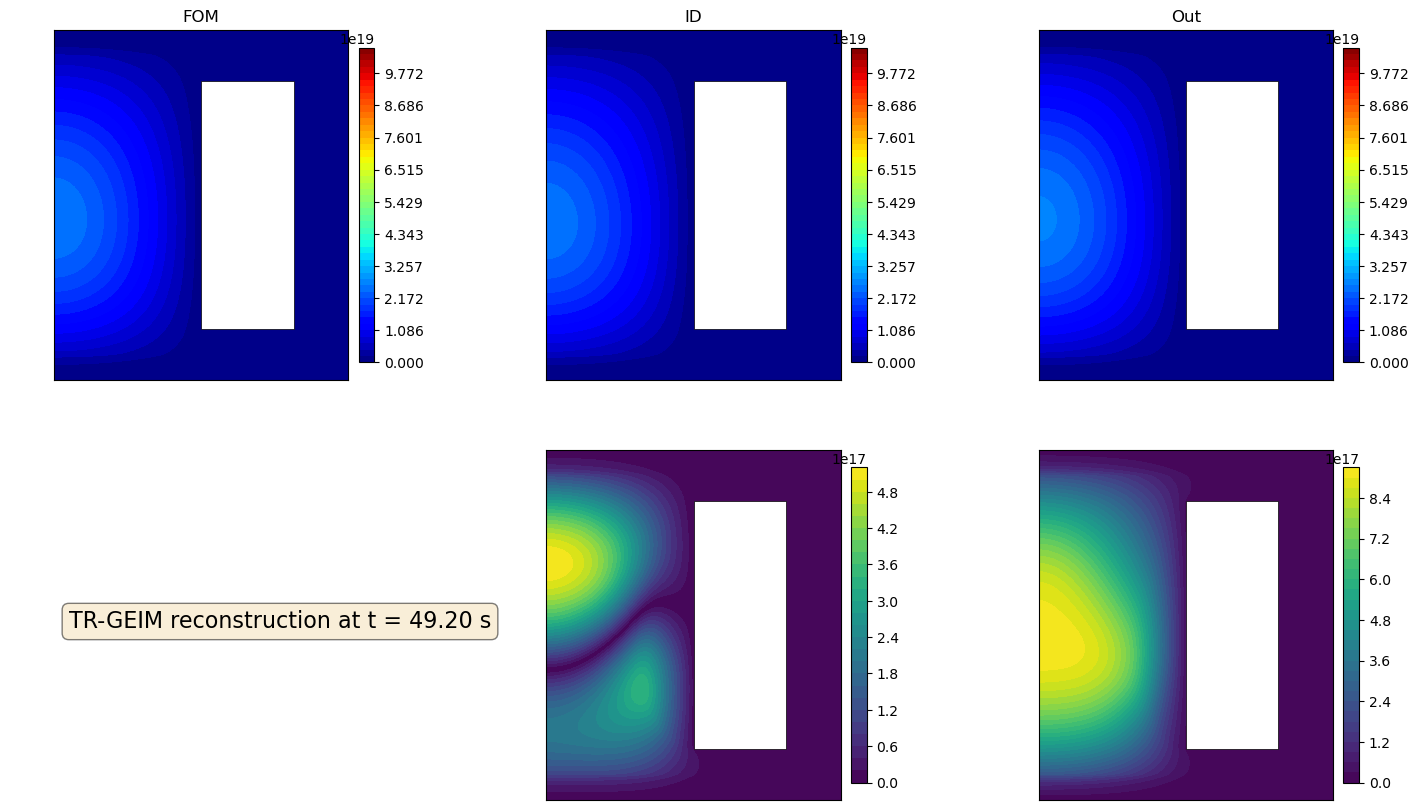

In [ ]:
from matplotlib import cm
from utils import plot_contour
from IPython.display import clear_output as clc

sampling = 10
mesh_plot = np.stack([domain.geometry.x[:, 0], domain.geometry.x[:, 2]]).T
rescale_factor = snaps[var_names[measured_field_i]](0).max()

levels = np.linspace(test_snaps.return_matrix().min(), test_snaps.return_matrix().max(), 50) * rescale_factor

for tt in range(sampling-1, len(test_snaps), sampling):

    fig, axs = plt.subplots(2, len(strategies)+1, figsize=((len(strategies)+1)*6, 10))

    cont = plot_contour(axs[0,0], mesh_plot, test_snaps(tt)*rescale_factor, levels=levels)
    fig.colorbar(cont, ax=axs[0,0], pad=0.025, shrink=0.9)
    axs[0,0].set_title('FOM')
    axs[1,0].axis('off')

    for i, strategy in enumerate(strategies):
        cont = plot_contour(axs[0,i+1], mesh_plot, recons[strategy][tt]*rescale_factor, levels=levels)
        fig.colorbar(cont, ax=axs[0,i+1], pad=0.025, shrink=0.9)
        axs[0,i+1].set_title(strategy)

        res_cont = plot_contour(axs[1,i+1], mesh_plot, np.abs(recons[strategy][tt] - test_snaps(tt))*rescale_factor, levels=30, cmap=cm.viridis)
        fig.colorbar(res_cont, ax=axs[1,i+1], pad=0.025, shrink=0.9)

    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="wheat", alpha=0.5)
    fig.text(0.275, 0.3, f'TR-GEIM reconstruction at t = {fom_times[test_indices[tt]]:.2f} s', 
             ha='center', va='top', fontsize=16, bbox=bbox_props)

    plt.show()
    clc(wait=True)
    plt.close(fig)

Let us plot the maximum value of the TR-GEIM reconstruction for the different strategies.

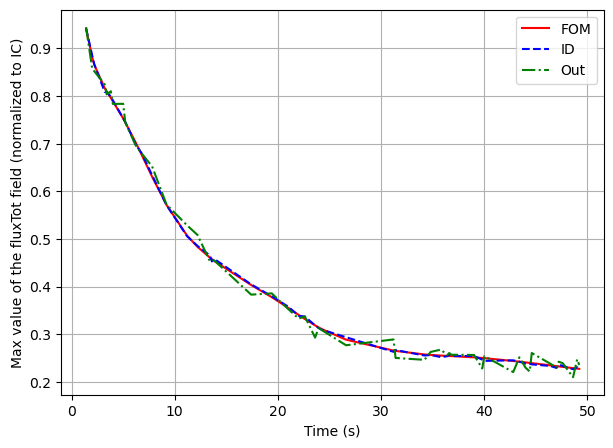

In [30]:
fig = plt.figure(figsize=(7, 5))

plt.plot(fom_times[test_indices], test_snaps.return_matrix().max(axis=0), 'r-', label='FOM')

colors = ['b', 'g', 'm']
linestyles = ['--', '-.', ':']
for i, strategy in enumerate(strategies):
    plt.plot(fom_times[test_indices], recons[strategy].max(axis=1), color=colors[i], linestyle=linestyles[i], label=strategy)

plt.xlabel('Time (s)')
plt.ylabel(f'Max value of the {var_names[measured_field_i]} field (normalized to IC)')
plt.grid()
plt.legend()

### Prediction regime
Let us now perform the online phase of TR-GEIM in prediction regime

In [32]:
online_pred_results = dict()

for strategy in strategies:
    print(f'Online prediction for {strategy} strategy')
    _res = trgeim[strategy].synt_test_error(    predict_snaps, 
                                                noise_value=noise_value, reg_param=reg_params, 
                                                M=25, verbose=False)

    online_pred_results[strategy] = {
        'abs_err': _res[0],
        'rel_err': _res[1],
        'compt_time': _res[2]
    }


Online prediction for ID strategy
The maximum number of measures must not be higher than 20 --> set equal to 20
Online prediction for Out strategy
The maximum number of measures must not be higher than 20 --> set equal to 20


Let us plot the absolute and relative error of the TR-GEIM reconstruction for the different strategies.

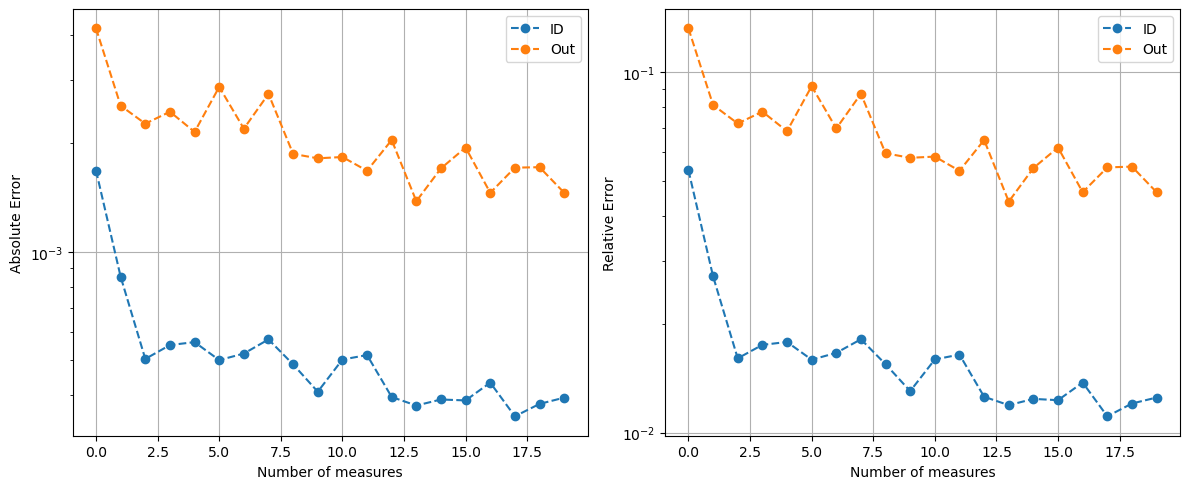

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for strategy in strategies:
    axs[0].plot(online_pred_results[strategy]['abs_err'], 'o--', label=strategy)
    axs[1].plot(online_pred_results[strategy]['rel_err'], 'o--', label=strategy)

for ax in axs:
    ax.grid()
    ax.set_xlabel('Number of measures')
    ax.set_yscale('log')
    ax.legend()

axs[0].set_ylabel('Absolute Error')
axs[1].set_ylabel('Relative Error')

plt.tight_layout()

Let us compare the computational time of the TR-GEIM estimation.

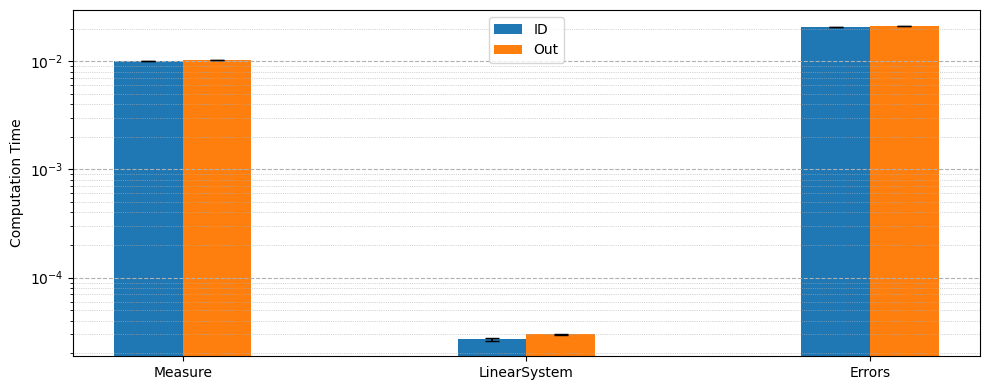

In [35]:
keys = ['Measure', 'LinearSystem', 'Errors']
strategies = list(online_pred_results.keys())

# Prepare data
means = []
errors = []

for key in keys:
    key_means = []
    key_errors = []
    for strategy in strategies:
        data = np.array(online_pred_results[strategy]['compt_time'][key])  
        mean_value = data.mean()
        std_err = data.std(ddof=1) / np.sqrt(data.size) 
        key_means.append(mean_value)
        key_errors.append(std_err)
    means.append(key_means)
    errors.append(key_errors)

means = np.array(means).T  
errors = np.array(errors).T

# Plot
x = np.arange(len(keys))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 4))
for i, strategy in enumerate(strategies):
    ax.bar(x + i*width, means[i], width, yerr=errors[i], label=strategy, capsize=5)

ax.set_xticks(x + width * (len(strategies)-1)/2)
ax.set_xticklabels(keys)
ax.set_ylabel('Computation Time')
ax.legend()
ax.set_yscale('log')
ax.grid(axis='y', linestyle='--')
ax.grid(axis='y', which='minor', linestyle=':', linewidth=0.5)


plt.tight_layout()

Let us make some contour plots of the TR-GEIM reconstruction for the different strategies.

At first, the reconstruction is generated.

In [36]:
recons = {
    strategy: np.array([trgeim[strategy].reconstruct(snap, M=Mmax, noise_value=noise_value, reg_param=reg_params)[0]
                        for snap in predict_snaps._list])
    for strategy in strategies
}

Then, the contour plots are generated.

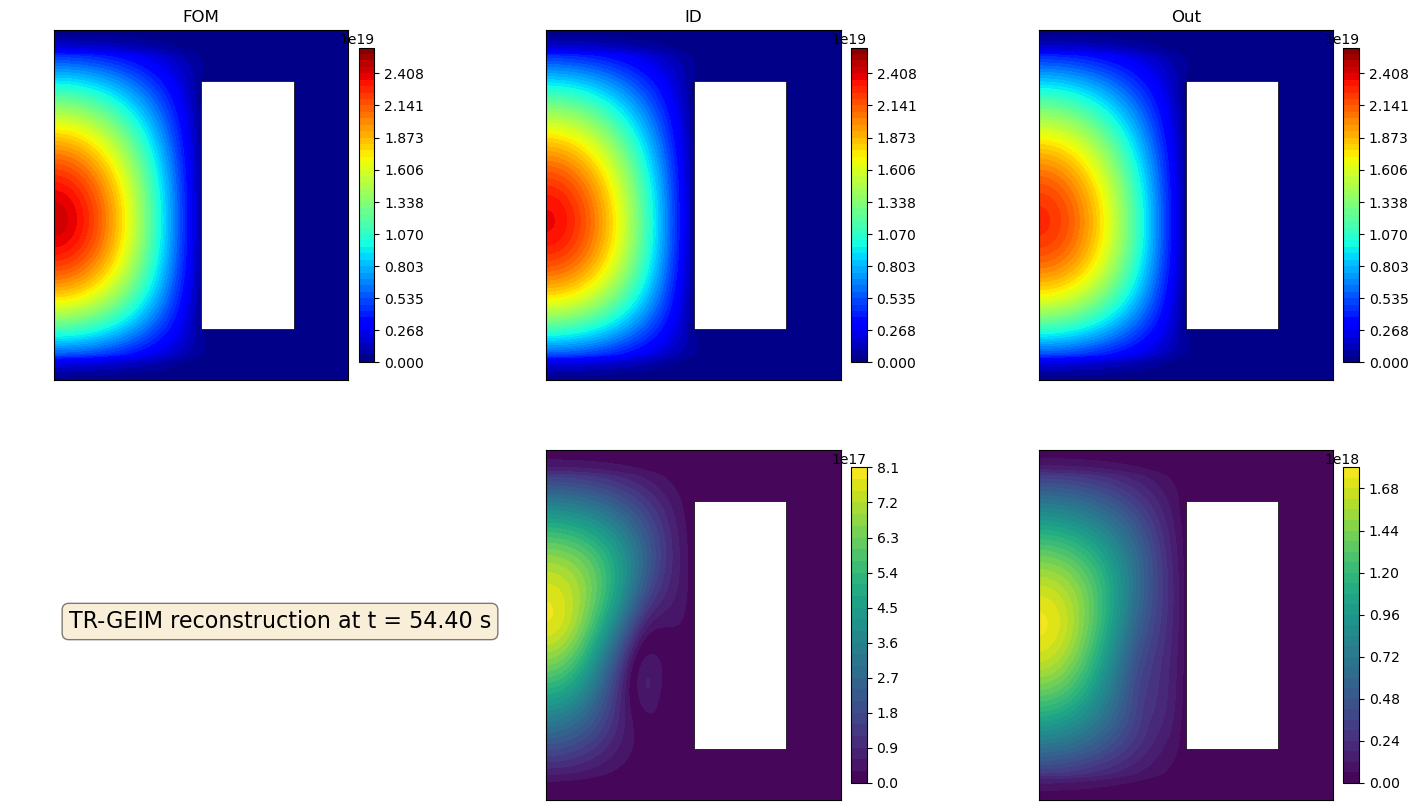

In [41]:
from matplotlib import cm
from utils import plot_contour

levels = np.linspace(predict_snaps.return_matrix().min()*0.975, predict_snaps.return_matrix().max()*1.025, 50)*rescale_factor
sampling = 5

for tt in range(sampling-1, len(predict_snaps), sampling):

    fig, axs = plt.subplots(2, len(strategies)+1, figsize=((len(strategies)+1)*6, 10))

    cont = plot_contour(axs[0,0], mesh_plot, predict_snaps(tt)*rescale_factor, levels=levels)
    fig.colorbar(cont, ax=axs[0,0], pad=0.025, shrink=0.9)
    axs[0,0].set_title('FOM')
    axs[1,0].axis('off')

    for i, strategy in enumerate(strategies):
        cont = plot_contour(axs[0,i+1], mesh_plot, recons[strategy][tt]*rescale_factor, levels=levels)
        fig.colorbar(cont, ax=axs[0,i+1], pad=0.025, shrink=0.9)
        axs[0,i+1].set_title(strategy)

        res_cont = plot_contour(axs[1,i+1], mesh_plot, np.abs(recons[strategy][tt] - predict_snaps(tt))*rescale_factor, levels=30, cmap=cm.viridis)
        fig.colorbar(res_cont, ax=axs[1,i+1], pad=0.025, shrink=0.9)

    bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="wheat", alpha=0.5)
    fig.text(0.275, 0.3, f'TR-GEIM reconstruction at t = {fom_times[predict_indices[tt]]:.2f} s', 
             ha='center', va='top', fontsize=16, bbox=bbox_props)

    plt.show()
    clc(wait=True)
    plt.close(fig)